In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from sklearn import (metrics, linear_model, preprocessing)
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
%matplotlib inline
import plotly.offline as py
from plotly import tools
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode , iplot , plot
init_notebook_mode(connected = True)
import cufflinks as cf
cf.go_offline()
import itertools
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from plotly import tools
from scipy.stats import norm

from sklearn import (metrics, linear_model, preprocessing)
# from sklearn.metrics import mean_squared_error , r2_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from statsmodels.tools import add_constant

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_rows', 200)

pd.options.mode.chained_assignment = None

path1 = 'Dataset/churn_data.csv'  # note i kept the csv file in dataset file so its easy to call from there
churn_data = pd.read_csv(path1, na_values='NA')

path2 = 'Dataset/customer_data.csv'
customer_data = pd.read_csv(path2 , na_values='NA')

path3 = 'Dataset/internet_data.csv'
internet_data = pd.read_csv(path3 , na_values='NA')

# Now merging the files into one file

# Merging on 'customerID'

In [3]:
df_1 = pd.merge(churn_data, customer_data, how='inner', on='customerID')

# Final dataframe with all predictor variables

In [4]:
df = pd.merge(df_1, internet_data, how='inner', on='customerID')

In [5]:
df.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


In [6]:
print('Customer Data - rows:' , df.shape[0],'columns:', df.shape[1])

Customer Data - rows: 7043 columns: 21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


In [8]:
# Check % of null values in df
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,StreamingMovies,gender,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,...,StreamingTV,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,customerID
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df.isna().any().any()

False

In [10]:
df.isna().sum()

customerID          0
tenure              0
PhoneService        0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [11]:
# Note this way we can see the data has got many categorical varialbes and we need to convert for our model
df.describe

<bound method NDFrame.describe of       customerID  tenure PhoneService        Contract PaperlessBilling  \
0     7590-VHVEG       1           No  Month-to-month              Yes   
1     5575-GNVDE      34          Yes        One year               No   
2     3668-QPYBK       2          Yes  Month-to-month              Yes   
3     7795-CFOCW      45           No        One year               No   
4     9237-HQITU       2          Yes  Month-to-month              Yes   
...          ...     ...          ...             ...              ...   
7038  6840-RESVB      24          Yes        One year              Yes   
7039  2234-XADUH      72          Yes        One year              Yes   
7040  4801-JZAZL      11           No  Month-to-month              Yes   
7041  8361-LTMKD       4          Yes  Month-to-month              Yes   
7042  3186-AJIEK      66          Yes        Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges Churn  gender  \

In [12]:
# Note here we can see all the stats on the numerical columns
df.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147
std,24.559481,30.090047,0.368612
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


In [13]:
# df is clean and has no null values

In [14]:
# Note - Total Charges column is an object we need to convert it into a float .

In [15]:
#Also the columns have missing values in the total charges columns that do not have been replaced with placeholders " "

In [16]:
# So we need to drop them .

In [17]:
df['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [18]:
df['TotalCharges'].dtype

dtype('O')

In [19]:
df['TotalCharges'] = df['TotalCharges'].replace(" ", 0).astype('float32')

In [20]:
df['tenure'].value_counts

<bound method IndexOpsMixin.value_counts of 0        1
1       34
2        2
3       45
4        2
        ..
7038    24
7039    72
7040    11
7041     4
7042    66
Name: tenure, Length: 7043, dtype: int64>

In [21]:
df['tenure'].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39])

In [22]:
df['tenure'].dtype

dtype('int64')

In [23]:
df.columns

Index(['customerID', 'tenure', 'PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [24]:
# EDA - 

In [25]:
#lets have a look at the distribution of Churn and no churn in df

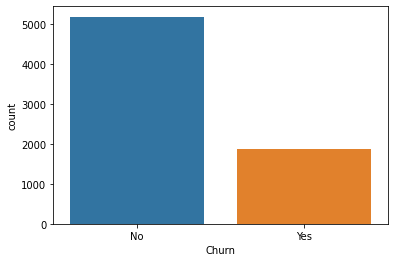

In [26]:
sns.countplot(df['Churn'])

# What is the percentage for churn and no churn customers

In [27]:
#labels
lab = df["Churn"].value_counts().keys().tolist()
#values
val = df["Churn"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'red'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

# Observation : In our data , 73.5% - Churn and 26.5% no churn rate

# Distribution of male and female customers

In [28]:
df['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

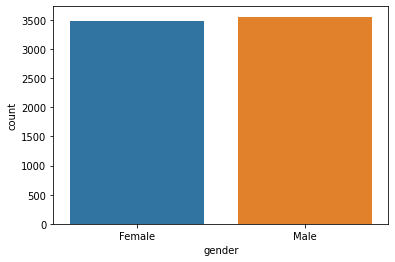

In [29]:
sns.countplot(df['gender'])

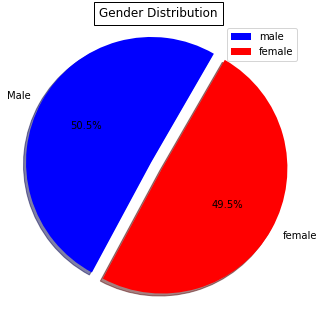

In [30]:
gender_val = ['male' , 'female']
gender = df['gender'].value_counts()

gender = gender.astype(float)
fig = plt.figure(figsize = (8,4))
ax = fig.add_axes((0,0,0.5,1))
ax.set_title('Gender Distribution' , bbox={'facecolor' : 'white' , 'pad':5})
labels = 'Male' , 'female'
colors = ['blue','red']
explode = (0.1 , 0)
plt.pie(gender , explode=explode , labels=labels , colors = colors , autopct = '%1.1f%%' , shadow = True , startangle=60)
plt.legend(labels=gender_val)
plt.axis('equal')
plt.show()

# Observation : Our customer base is pretty balanced though we have just a few more male customers over females

In [31]:
#labels
lab = df["gender"].value_counts().keys().tolist()
#values
val = df["gender"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'red'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

# Get Categorical Variables

In [32]:
def get_cat(df):
    """get list of cat features from df"""
    cat = []
    for x in df.columns:
        if df[x].dtypes == 'object':
            cat.append(x)
    return cat

cat1 = get_cat(df)

In [33]:
cat1

['customerID',
 'PhoneService',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'gender',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

# Get Numerical variables in df

In [34]:
def get_nom(df):
    """get nom features"""
    nom = []
    for x in df.columns:
        if df[x].dtypes != 'object':
            nom.append(x)
    return nom[2:] # no need for feature id and age but customise according to df

nom1 = get_nom(df)

In [35]:
nom1

['TotalCharges', 'SeniorCitizen']

# Density plot of DataFrame

In [36]:
# Note there are only 3 actual numerical columns in the dataframe

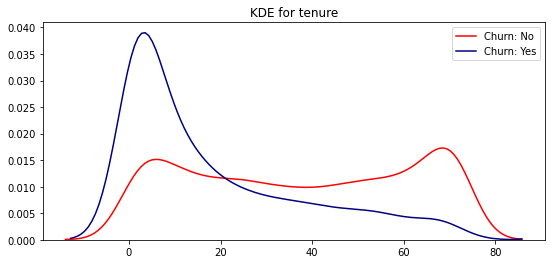

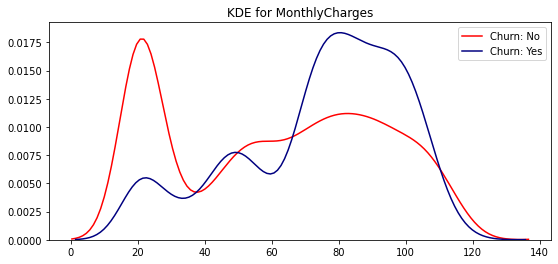

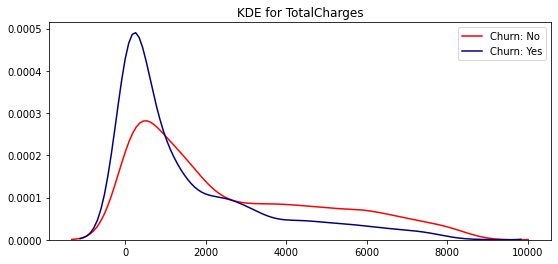

In [37]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Churn'] == 'No'][feature].dropna(), color= 'red', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Churn'] == 'Yes'][feature].dropna(), color= 'navy', label= 'Churn: Yes')
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

# Observation:

From the plots above we can conclude that:

Recent clients are more likely to churn
Clients with higher MonthlyCharges are also more likely to churn
Tenure and MonthlyCharges are probably important features
In fact we can see some boundaries when we use scatter plots:

In [38]:
df0 = df.copy()

# Gender and Age

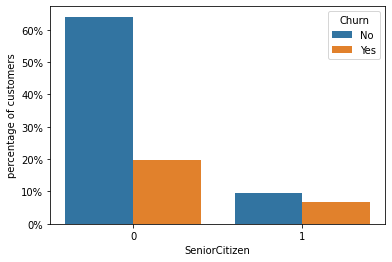

In [39]:
def barplot_percentages(feature, orient='v', axis_name="percentage of customers"):
    ratios = pd.DataFrame()
    m = df.groupby(feature)["Churn"].value_counts().to_frame()
    m = m.rename({"Churn": axis_name}, axis=1).reset_index()
    m[axis_name] = m[axis_name]/len(df)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='Churn', data= m, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='Churn', data= m, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
barplot_percentages("SeniorCitizen")

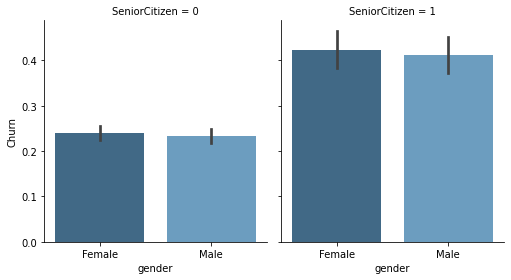

In [53]:
df0['churn_rate'] = df0['Churn'].replace("No", 0).replace("Yes", 1)
g = sns.FacetGrid(df, col="SeniorCitizen", height=4, aspect=.9 )
ax = g.map(sns.barplot, "gender", "Churn", palette = "Blues_d", order= ['Female', 'Male'])

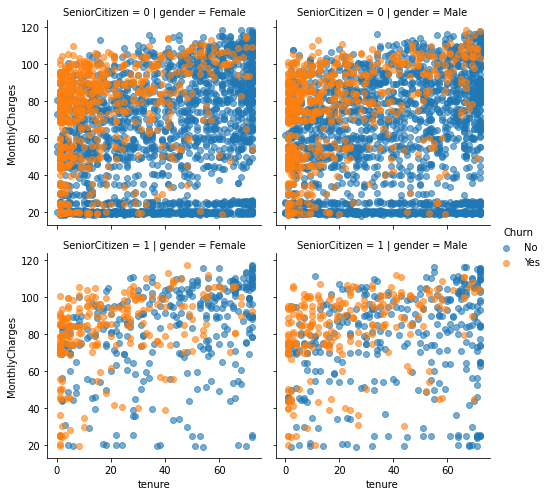

In [41]:
x = sns.FacetGrid(df, row='SeniorCitizen', col="gender", hue="Churn", height=3.5)
x.map(plt.scatter, "tenure", "MonthlyCharges", alpha=0.6)
x.add_legend();

# Observations

Gender is not an indicative of churn.

SeniorCitizens are only 16% of customers, but they have a much higher churn rate: 42% against 23% for non-senior customers.

There are no special relations between this categorical values and the main numerical features.

# Partner and dependents

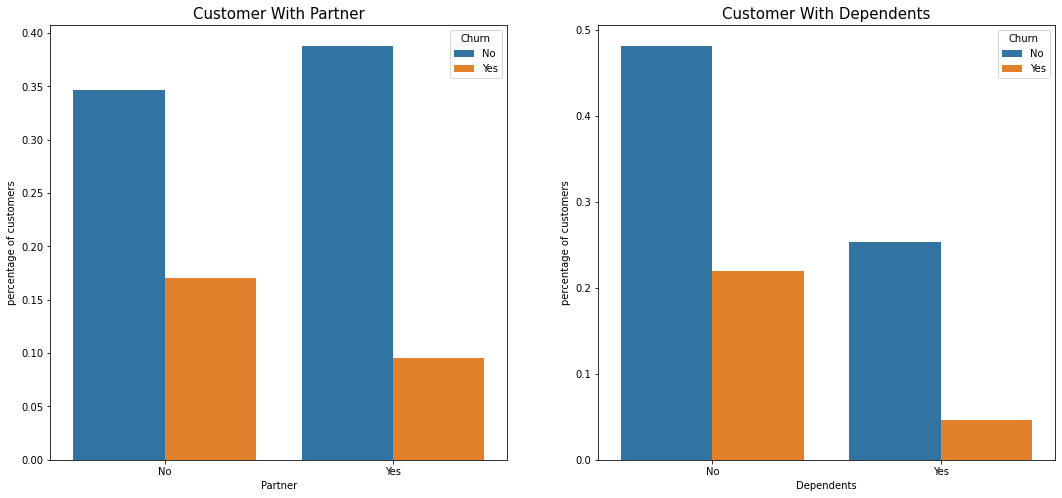

In [42]:
fig, axis = plt.subplots(1, 2, figsize=(18,8))
axis[0].set_title("Customer With Partner" , fontsize = 15)
axis[1].set_title("Customer With Dependents" , fontsize = 15)
axis_y = "percentage of customers"
# Plot Partner column
gp_partner = df.groupby('Partner')["Churn"].value_counts()/len(df)
gp_partner = gp_partner.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Partner', y= axis_y, hue='Churn', data=gp_partner, ax=axis[0])
# Plot Dependents column
gp_dep = df.groupby('Dependents')["Churn"].value_counts()/len(df)
gp_dep = gp_dep.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Dependents', y= axis_y, hue='Churn', data=gp_dep, ax=axis[1])

# Observations

- Customers who do not have partners are more likely to churn

- Customers without dependents are also more likely to churn

# Phone services

There are only two features here: if the client has phone and if he has more than one line. Both can be summed up in one chart:

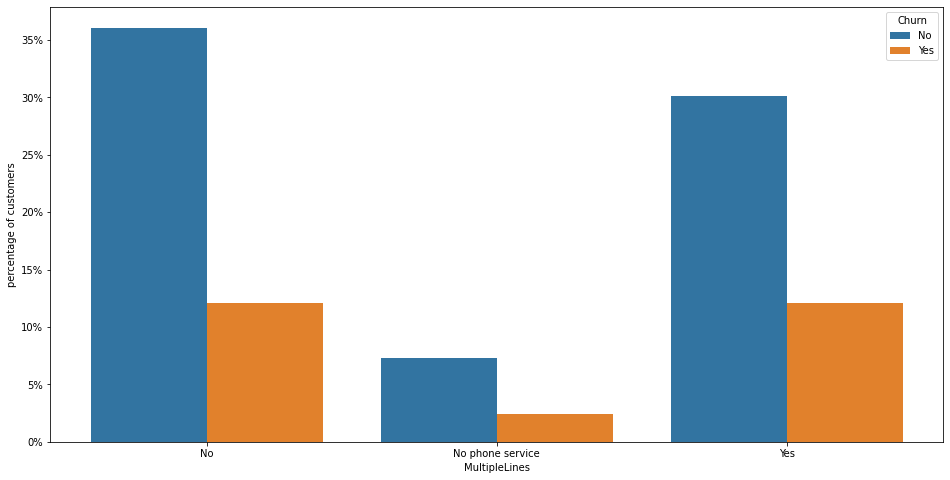

In [43]:
plt.figure(figsize=(16, 8))
barplot_percentages("MultipleLines", orient='v')

# Observation

- Only a few customers doesn't have phone service

- Customers with multiple lines have a slightly higher churn rate


# How does having multiple lines affects the monthly charges:

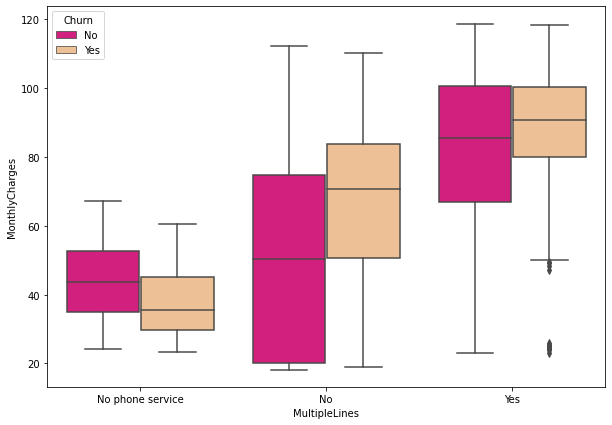

In [44]:
# Change to boxplot
fig ,ax = plt.subplots(figsize = (10,7))
ax = sns.boxplot(x="MultipleLines", y="MonthlyCharges", hue="Churn"
                 , palette="Accent_r", data=df)

# Feature Engineering - Dealing with Categorical columns

In [ ]:
# Converting Yes to 1 and No to 0

In [45]:
df['PhoneService'] = df['PhoneService'].map({'Yes' : 1 , 'No' : 0})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes' : 1 , 'No' : 0})
df['Churn'] = df['Churn'].map({'Yes' : 1 , 'No' : 0})
df['Partner'] = df['Partner'].map({'Yes' : 1 , 'No':0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})


# Creating dummy variables for the categorical variables

In [52]:
df.columns

Index(['customerID', 'tenure', 'PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [54]:
# Creating a dummy variable for the variable 'Contract' and dropping the first one.
contract = pd.get_dummies(df['Contract'],prefix='Contract',drop_first=True)
#Adding the results to the master dataframe
df = pd.concat([df,contract],axis=1)

# Creating a dummy variable for the variable 'PaymentMethod' and dropping the first one.
paymentMethod = pd.get_dummies(df['PaymentMethod'],prefix='PaymentMethod',drop_first=True)
#Adding the results to the master dataframe
df = pd.concat([df,paymentMethod],axis=1)

# Creating a dummy variable for the variable 'gender' and dropping the first one.
gender = pd.get_dummies(df['gender'],prefix='gender',drop_first=True)
#Adding the results to the master dataframe
df = pd.concat([df,gender],axis=1)

# Creating a dummy variable for the variable 'MultipleLines' and dropping the first one.
multipleLines = pd.get_dummies(df['MultipleLines'],prefix='MultipleLines')
#  dropping MultipleLines_No phone service column
multipleLines = multipleLines.drop(['MultipleLines_No phone service'],1)
#Adding the results to the master dataframe
df = pd.concat([df, multipleLines],axis=1)

# Creating a dummy variable for the variable 'InternetService' and dropping the first one.
internetService = pd.get_dummies(df['InternetService'],prefix='InternetService',drop_first=True)
#Adding the results to the master dataframe
df = pd.concat([df,internetService],axis=1)

# Creating a dummy variable for the variable 'OnlineSecurity'.
onlineSec = pd.get_dummies(df['OnlineSecurity'],prefix='OnlineSecurity')
onlineSec = onlineSec.drop(['OnlineSecurity_No internet service'],1)
#Adding the results to the master dataframe
df = pd.concat([df,onlineSec],axis=1)

# Creating a dummy variable for the variable 'OnlineBackup'.
onlinebackup =pd.get_dummies(df['OnlineBackup'],prefix='OnlineBackup')
onlinebackup =onlinebackup.drop(['OnlineBackup_No internet service'],1)
#Adding the results to the master dataframe
df = pd.concat([df,onlinebackup],axis=1)

# Creating a dummy variable for the variable 'DeviceProtection'. 
DeviceProtection =pd.get_dummies(df['DeviceProtection'],prefix='DeviceProtection')
DeviceProtection = DeviceProtection.drop(['DeviceProtection_No internet service'],1)
#Adding the results to the master dataframe
DeviceProtection = pd.concat([df,DeviceProtection],axis=1)

# Creating a dummy variable for the variable 'TechSupport'. 
techsupport = pd.get_dummies(df['TechSupport'],prefix='TechSupport')
techsupport = techsupport.drop(['TechSupport_No internet service'],1)
#Adding the results to the master dataframe
df = pd.concat([df,techsupport],axis=1)

# Creating a dummy variable for the variable 'StreamingTV'.
StreamingTV =pd.get_dummies(df['StreamingTV'],prefix='StreamingTV')
StreamingTV = StreamingTV.drop(['StreamingTV_No internet service'],1)
#Adding the results to the master dataframe
df = pd.concat([df,StreamingTV],axis=1)

# Creating a dummy variable for the variable 'StreamingMovies'. 
StreamingMovies =pd.get_dummies(df['StreamingMovies'],prefix='StreamingMovies')
StreamingMovies = StreamingMovies.drop(['StreamingMovies_No internet service'],1)
#Adding the results to the master dataframe
df = pd.concat([df,StreamingMovies],axis=1)

In [ ]:
# Checking results

In [55]:
df.columns

Index(['customerID', 'tenure', 'PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'MultipleLines_No', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_Yes', 'TechSupport_No', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No',
       'StreamingMovies_Yes'],
      dtype='object')

# I have succesfully dropped all the columns here and set drop first to true to prevent Multicollinearity

In [ ]:
# Check results of dataframe

In [56]:
df.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.850000,0,Female,...,1,0,0,1,1,0,1,0,1,0
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.500000,0,Male,...,0,1,1,0,1,0,1,0,1,0
2,3668-QPYBK,2,1,Month-to-month,1,Mailed check,53.85,108.150002,1,Male,...,0,1,0,1,1,0,1,0,1,0
3,7795-CFOCW,45,0,One year,0,Bank transfer (automatic),42.30,1840.750000,0,Male,...,0,1,1,0,0,1,1,0,1,0
4,9237-HQITU,2,1,Month-to-month,1,Electronic check,70.70,151.649994,1,Female,...,1,0,1,0,1,0,1,0,1,0


# Note here we can see above that we still example male and female in the gender column so we need to drop this columns

# Dropping the repeated columns since i have created dummy variables for them

In [57]:
# We have created dummies for the below variables, so we can drop them
df_new = df.drop(['Contract','PaymentMethod','gender','MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport','StreamingTV', 'StreamingMovies'], 1)

In [58]:
df_new.head()

,customerID,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,...,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,7590-VHVEG,1,0,1,29.85,29.850000,0,0,1,0,...,1,0,0,1,1,0,1,0,1,0
1,5575-GNVDE,34,1,0,56.95,1889.500000,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
2,3668-QPYBK,2,1,1,53.85,108.150002,1,0,0,0,...,0,1,0,1,1,0,1,0,1,0
3,7795-CFOCW,45,0,0,42.30,1840.750000,0,0,0,0,...,0,1,1,0,0,1,1,0,1,0
4,9237-HQITU,2,1,1,70.70,151.649994,1,0,0,0,...,1,0,1,0,1,0,1,0,1,0


In [59]:
len(df_new.columns)

30

In [60]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   tenure                                 7043 non-null   int64  
 2   PhoneService                           7043 non-null   int64  
 3   PaperlessBilling                       7043 non-null   int64  
 4   MonthlyCharges                         7043 non-null   float64
 5   TotalCharges                           7043 non-null   float32
 6   Churn                                  7043 non-null   int64  
 7   SeniorCitizen                          7043 non-null   int64  
 8   Partner                                7043 non-null   int64  
 9   Dependents                             7043 non-null   int64  
 10  Contract_One year                      7043 non-null   uint8  
 11  Cont

In [61]:
# run this if anything goes wrong and you need to avoid restarting the kernel
df_new1 = df_new.copy()

In [62]:
# df_new = df_new1.copy()

# Checking for outliers

In [63]:
num_df = df_new[['tenure','MonthlyCharges','SeniorCitizen','TotalCharges']]

# Checking outliers at 25%,50%,75%,90%,95% and 99% Percentiles in on go

In [64]:
num_df.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,tenure,MonthlyCharges,SeniorCitizen,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147,2279.734375
std,24.559481,30.090047,0.368612,2266.794434
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.500000,0.000000,398.549988
50%,29.000000,70.350000,0.000000,1394.550049
75%,55.000000,89.850000,0.000000,3786.599976
90%,69.000000,102.600000,1.000000,5973.689844
95%,72.000000,107.400000,1.000000,6921.025195
99%,72.000000,114.729000,1.000000,8039.256025


# Observation

### From the distribution shown above, you can see that there no outliers in the data. The numbers are gradually increasing.

In [65]:
# Removing NaN TotalCharges rows
df_new = df_new[~np.isnan(df_new['TotalCharges'])]

In [66]:
# Checking percentage of missing values after removing the missing values
round(100*(df_new.isnull().sum()/len(df_new.index)), 2)

customerID                               0.0
tenure                                   0.0
PhoneService                             0.0
PaperlessBilling                         0.0
MonthlyCharges                           0.0
TotalCharges                             0.0
Churn                                    0.0
SeniorCitizen                            0.0
Partner                                  0.0
Dependents                               0.0
Contract_One year                        0.0
Contract_Two year                        0.0
PaymentMethod_Credit card (automatic)    0.0
PaymentMethod_Electronic check           0.0
PaymentMethod_Mailed check               0.0
gender_Male                              0.0
MultipleLines_No                         0.0
MultipleLines_Yes                        0.0
InternetService_Fiber optic              0.0
InternetService_No                       0.0
OnlineSecurity_No                        0.0
OnlineSecurity_Yes                       0.0
OnlineBack

# Standardization of Features

In [ ]:
# here we normalize our continues variables

In [67]:
df1 = df_new[['tenure','MonthlyCharges','TotalCharges']]

In [68]:
normalized_df=(df1 - df1.mean())/df1.std()

In [69]:
# dropping the continues columns from the dataframe 
df_new = df_new.drop(['tenure','MonthlyCharges','TotalCharges'], 1)

In [70]:
# Concatnating normalized columns to dataframe
df_new = pd.concat([df_new, normalized_df],axis=1)

In [71]:
# Check results
df_new

,customerID,PhoneService,PaperlessBilling,Churn,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),...,OnlineBackup_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,tenure,MonthlyCharges,TotalCharges
0,7590-VHVEG,0,1,0,0,1,0,0,0,0,...,1,1,0,1,0,1,0,-1.277354,-1.160241,-0.992540
1,5575-GNVDE,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,1,0,0.066323,-0.259611,-0.172153
2,3668-QPYBK,1,1,1,0,0,0,0,0,0,...,1,1,0,1,0,1,0,-1.236636,-0.362635,-0.957998
3,7795-CFOCW,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,1,0,0.514215,-0.746482,-0.193659
4,9237-HQITU,1,1,1,0,0,0,0,0,0,...,0,1,0,1,0,1,0,-1.236636,0.197351,-0.938808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,1,0,0,1,1,1,0,0,...,0,0,1,0,1,0,1,-0.340852,0.665945,-0.127596
7039,2234-XADUH,1,1,0,0,1,1,1,0,1,...,1,1,0,0,1,0,1,1.613587,1.277443,2.242447
7040,4801-JZAZL,0,1,0,0,1,1,0,0,0,...,0,1,0,1,0,1,0,-0.870179,-1.168549,-0.852872
7041,8361-LTMKD,1,1,1,1,1,0,0,0,0,...,0,1,0,1,0,1,0,-1.155201,0.320315,-0.870451


# Model Our Building

In [72]:
from sklearn.model_selection import train_test_split
X = df_new.drop(['customerID' , 'Churn'] , 1)

y = df_new['Churn']


In [73]:
X_train , x_test , y_train , y_test = train_test_split(X , y , test_size = 0.30 , random_state = 100)

# Running my first Model

In [74]:
import statsmodels.api as sm
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4930
Model:                            GLM   Df Residuals:                     4907
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2008.5
Date:                Fri, 22 May 2020   Deviance:                       4017.0
Time:                        17:32:24   Pearson chi2:                 5.79e+03
No. Iterations:                    67                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.5671      0.532     -2.945      0.003      -2.610      -0.524
PhoneService                             -0.0313      0.276     -0.113      0.910      -0.572       0.509
PaperlessBilling                          0.3460      0.090      3.836      0.000       0.169       0.523
SeniorCitizen                             0.2943      0.102      2.871      0.004       0.093       0.495
Partner                                   0.0313      0.094      0.333      0.739      -0.153       0.215
Dependents                               -0.2228      0.108     -2.070      0.038      -0.434      -0.012
Contract_One year                        -0.6692      0.129     -5.175      0.000      -0.923      -0.416
Contract_Two year                        -1.3296      0.207     -6.420      0.000      -1.735      -0.924
PaymentMethod_Credit card (automatic)    -0.1510      0.138     -1.094      0.274      -0.422       0.120
PaymentMethod_Electronic check            0.2724      0.114      2.388      0.017       0.049       0.496
PaymentMethod_Mailed check               -0.0909      0.139     -0.655      0.512      -0.363       0.181
gender_Male                              -0.0414      0.078     -0.528      0.598      -0.195       0.112
MultipleLines_No                         -0.2111      0.108     -1.953      0.051      -0.423       0.001
MultipleLines_Yes                         0.1798      0.186      0.968      0.333      -0.184       0.544
InternetService_Fiber optic               1.2126      0.446      2.719      0.007       0.338       2.087
InternetService_No                       -1.5015      0.598     -2.512      0.012      -2.673      -0.330
OnlineSecurity_No                         0.0698      0.053      1.315      0.188      -0.034       0.174
OnlineSecurity_Yes                       -0.1354      0.095     -1.424      0.154      -0.322       0.051
OnlineBackup_No                           0.0576      0.049      1.171      0.242      -0.039       0.154
OnlineBackup_Yes                         -0.1232      0.093     -1.320      0.187      -0.306       0.060
TechSupport_No                            0.1742      0.054      3.198      0.001       0.067       0.281
TechSupport_Yes                          -0.2399      0.099     -2.422      0.015      -0.434      -0.046
StreamingTV_No                           -0.2223      0.075     -2.957      0.003      -0.370      -0.075
StreamingTV_Yes                           0.1567      0.135      1.157      0.247      -0.109       0.422
StreamingMovies_No                       -0.2071      0.076     -2.737      0.006      -0.355      -0.059
StreamingMovies_Yes                       0.1415      0.136      1.044      0.296      -0.124       0.407
tenure   

# Lets check our Correlation Matrix

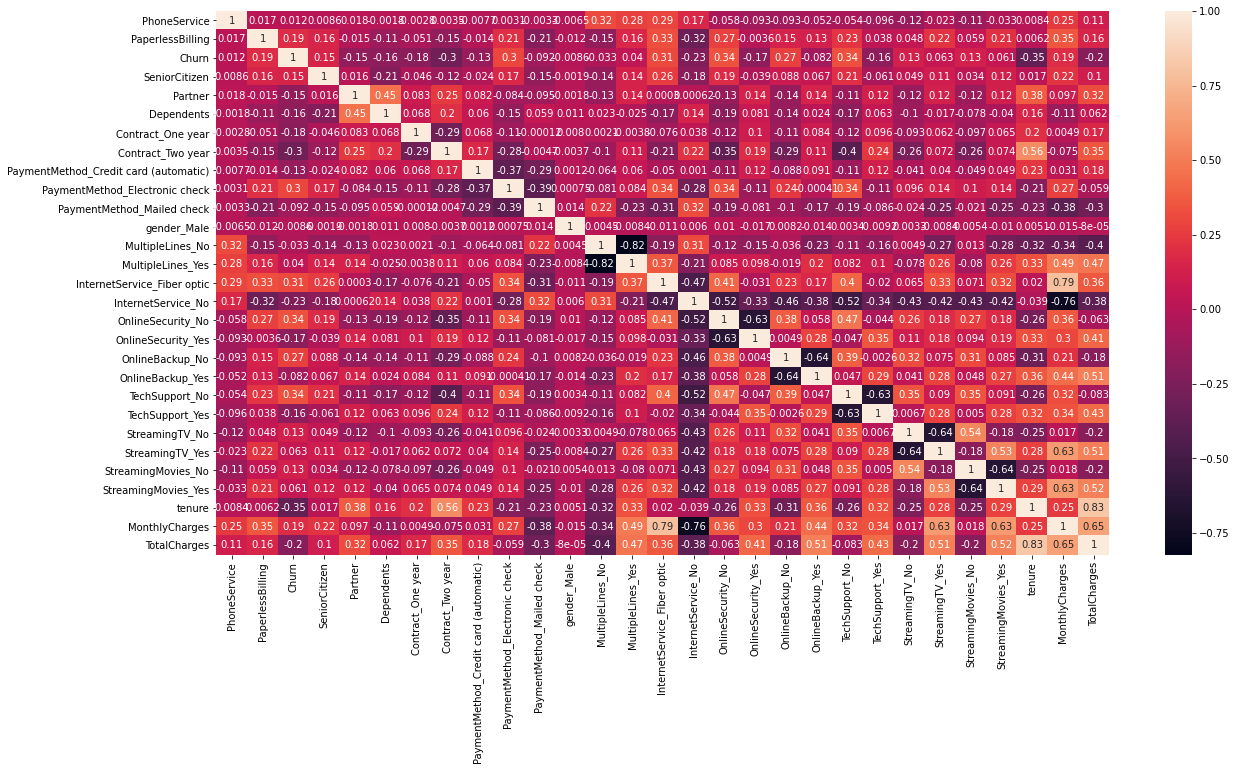

In [75]:
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(df_new.corr(),annot = True)
plt.show()

# Checking Max and Min correlation between variables

In [76]:
def correl(X_train):
    cor = X_train.corr()
    corrm = np.corrcoef(X_train.transpose())
    corr = corrm - np.diagflat(corrm.diagonal())
    print("max corr:",corr.max(), ", min corr: ", corr.min())
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    high_cor = c1[c1.values!=1]
    ## change this value to get more correlation results        
    thresh = 0.9
    display(high_cor[high_cor>thresh])
correl(X)

max corr: 0.826178397830468 , min corr:  -0.8228533739770163


Series([], dtype: float64)

In [77]:
# Come here if anything goes wrong 
full_df1 = df_new.copy()

# Removing Highly correlated features from dataframe

In [78]:
corr_data = full_df1.corr()['Churn'].sort_values(ascending = False)
print(corr_data.tail)

<bound method NDFrame.tail of Churn                                    1.000000
OnlineSecurity_No                        0.342637
TechSupport_No                           0.337281
InternetService_Fiber optic              0.308020
PaymentMethod_Electronic check           0.301919
OnlineBackup_No                          0.268005
MonthlyCharges                           0.193356
PaperlessBilling                         0.191825
SeniorCitizen                            0.150889
StreamingMovies_No                       0.130845
StreamingTV_No                           0.128916
StreamingTV_Yes                          0.063228
StreamingMovies_Yes                      0.061382
MultipleLines_Yes                        0.040102
PhoneService                             0.011942
gender_Male                             -0.008612
MultipleLines_No                        -0.032569
OnlineBackup_Yes                        -0.082255
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit

In [79]:
corr_data.head(11)

Churn                             1.000000
OnlineSecurity_No                 0.342637
TechSupport_No                    0.337281
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
OnlineBackup_No                   0.268005
MonthlyCharges                    0.193356
PaperlessBilling                  0.191825
SeniorCitizen                     0.150889
StreamingMovies_No                0.130845
StreamingTV_No                    0.128916
Name: Churn, dtype: float64

In [ ]:
# X_train.columns

# Dropping highly correlated variables.

In [ ]:
# 'OnlineSecurity_No'                        
# 'TechSupport_No'                           
# 'InternetService_Fiber optic'              
# 'PaymentMethod_Electronic check'          
# 'OnlineBackup_No'                          
# 'MonthlyCharges'              
# 'PaperlessBilling'                         
# 'SeniorCitizen'                           
# 'StreamingMovies_No'                       
# 'StreamingTV_No'

In [81]:
X_test2 = x_test.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','MonthlyCharges','TechSupport_No','StreamingTV_No','StreamingMovies_No'
                      ,'PaperlessBilling','SeniorCitizen'],1)




X_train2 = X_train.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','MonthlyCharges','TechSupport_No','StreamingTV_No','StreamingMovies_No'
                      ,'PaperlessBilling','SeniorCitizen'] ,1)

# Checking the Correlation Matrix

After dropping highly correlated variables now let's check the correlation matrix again.

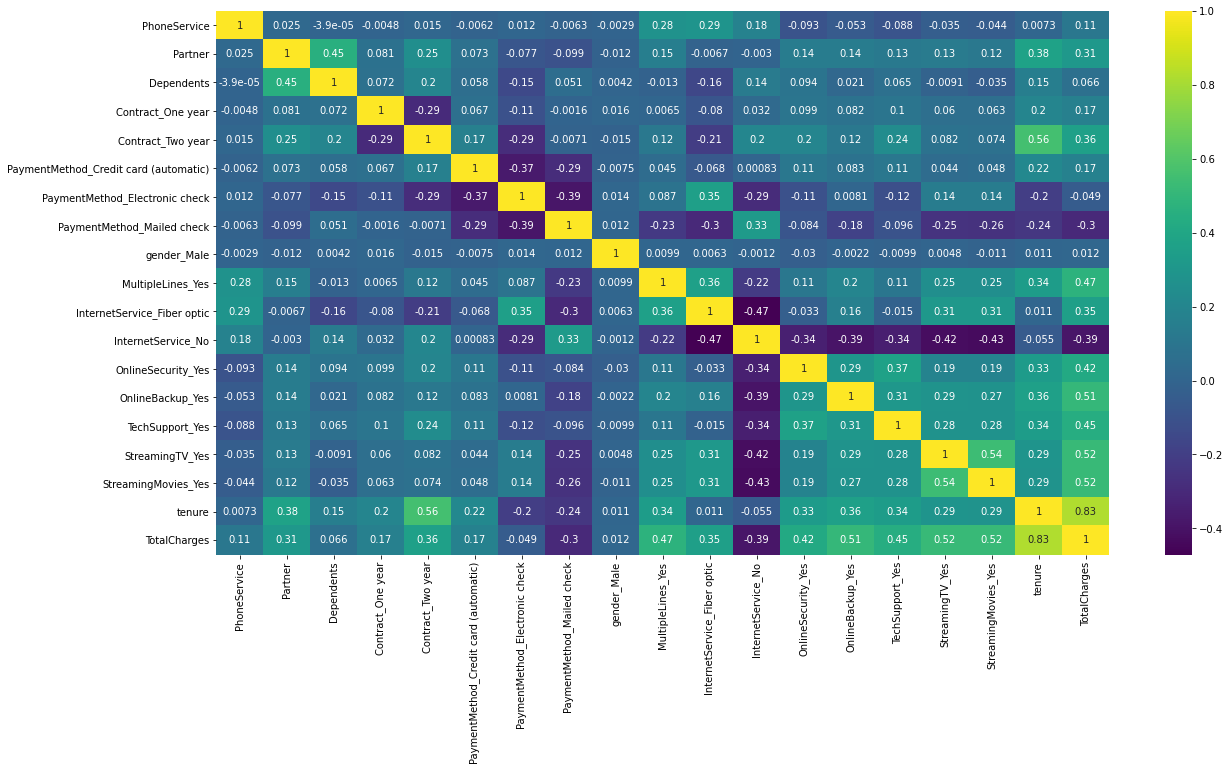

In [82]:
plt.figure(figsize = (20,10))
sns.heatmap(X_train2.corr(),annot = True , cmap = 'viridis')

In [ ]:
# Now after dropping the highly correlated variables , lets re-run our model

In [83]:
# Logistic regression model
logmodel2 = sm.GLM(y_train,(sm.add_constant(X_train2)), family = sm.families.Binomial())
logmodel2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4930
Model:                            GLM   Df Residuals:                     4910
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2021.0
Date:                Fri, 22 May 2020   Deviance:                       4042.1
Time:                        17:35:56   Pearson chi2:                 5.70e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.7204      0.193     -3.727      0.000      -1.099      -0.342
PhoneService                             -0.6263      0.158     -3.960      0.000      -0.936      -0.316
Partner                                   0.0562      0.093      0.605      0.545      -0.126       0.238
Dependents                               -0.2956      0.106     -2.799      0.005      -0.503      -0.089
Contract_One year                        -0.7409      0.128     -5.785      0.000      -0.992      -0.490
Contract_Two year                        -1.4240      0.206     -6.921      0.000      -1.827      -1.021
PaymentMethod_Credit card (automatic)    -0.1399      0.138     -1.016      0.310      -0.410       0.130
PaymentMethod_Electronic check            0.3040      0.114      2.676      0.007       0.081       0.527
PaymentMethod_Mailed check               -0.1054      0.138     -0.763      0.446      -0.376       0.165
gender_Male                              -0.0393      0.078     -0.504      0.615      -0.192       0.114
MultipleLines_Yes                         0.3324      0.096      3.476      0.001       0.145       0.520
InternetService_Fiber optic               0.8268      0.118      6.983      0.000       0.595       1.059
InternetService_No                       -0.9795      0.164     -5.957      0.000      -1.302      -0.657
OnlineSecurity_Yes                       -0.3192      0.102     -3.138      0.002      -0.519      -0.120
OnlineBackup_Yes                         -0.2534      0.093     -2.728      0.006      -0.435      -0.071
TechSupport_Yes                          -0.5381      0.104     -5.199      0.000      -0.741      -0.335
StreamingTV_Yes                           0.2210      0.098      2.261      0.024       0.029       0.412
StreamingMovies_Yes                       0.1748      0.097      1.794      0.073      -0.016       0.366
tenure                                   -1.2913      0.178     -7.271      0.000      -1.639      -0.943
TotalCharges                              0.5701      0.187      3.044      0.002       0.203       0.937
=========================================================================================================
"""

# Feature Selection using RFE

In [84]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 13)             # running RFE with 13 variables as output
rfe = rfe.fit(X,y)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)          # Printing the ranking

[False  True False False False  True  True False  True False False  True
 False  True  True  True False False False False False False  True False
  True  True  True  True]
[ 5  1  3 16  4  1  1  8  1  9 13  1 12  1  1  1  7  6 11  2 10 15  1 14
  1  1  1  1]


In [86]:
# Variables selected by RFE 
col = ['PhoneService', 'PaperlessBilling', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Electronic check','MultipleLines_No','InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Yes','TechSupport_Yes','StreamingMovies_No','tenure','TotalCharges']

In [87]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression()
logsk.fit(X_train[col], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
#Comparing the model with StatsModels
logm4 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
logm4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4930
Model:                            GLM   Df Residuals:                     4916
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2023.5
Date:                Fri, 22 May 2020   Deviance:                       4047.0
Time:                        17:37:39   Pearson chi2:                 5.85e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.9151      0.164     -5.575      0.000      -1.237      -0.593
PhoneService                      -0.3158      0.170     -1.857      0.063      -0.649       0.017
PaperlessBilling                   0.3712      0.089      4.158      0.000       0.196       0.546
Contract_One year                 -0.7240      0.127     -5.679      0.000      -0.974      -0.474
Contract_Two year                 -1.4016      0.205     -6.830      0.000      -1.804      -0.999
PaymentMethod_Electronic check     0.3793      0.083      4.573      0.000       0.217       0.542
MultipleLines_No                  -0.3239      0.095     -3.398      0.001      -0.511      -0.137
InternetService_Fiber optic        0.8252      0.118      7.009      0.000       0.594       1.056
InternetService_No                -1.1190      0.179     -6.243      0.000      -1.470      -0.768
OnlineSecurity_Yes                -0.3227      0.101     -3.185      0.001      -0.521      -0.124
TechSupport_Yes                   -0.5331      0.103     -5.165      0.000      -0.735      -0.331
StreamingMovies_No                -0.2307      0.094     -2.461      0.014      -0.414      -0.047
tenure                            -1.3390      0.173     -7.741      0.000      -1.678      -1.000
TotalCharges                       0.5852      0.180      3.259      0.001       0.233       0.937
==================================================================================================
"""

In [89]:
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [90]:
df_new.columns
['PhoneService', 'PaperlessBilling', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Electronic check','MultipleLines_No','InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Yes','TechSupport_Yes','StreamingMovies_No','tenure','TotalCharges']

['PhoneService',
 'PaperlessBilling',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Electronic check',
 'MultipleLines_No',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_Yes',
 'TechSupport_Yes',
 'StreamingMovies_No',
 'tenure',
 'TotalCharges']

In [91]:
# Calculating Vif value
vif_cal(input_data=df_new.drop(['customerID','SeniorCitizen', 'Partner', 'Dependents',
                                 'PaymentMethod_Credit card (automatic)','PaymentMethod_Mailed check',
                                 'gender_Male','MultipleLines_Yes','OnlineSecurity_No','OnlineBackup_No',
                                 'OnlineBackup_Yes',
                                 'TechSupport_No','StreamingTV_No','StreamingTV_Yes','StreamingMovies_Yes',
                                 'MonthlyCharges'], axis=1), dependent_col='Churn')

,Var,Vif
0,PhoneService,10.85
12,TotalCharges,8.57
11,tenure,6.74
1,PaperlessBilling,2.61
7,InternetService_No,0.66
3,Contract_Two year,0.29
9,TechSupport_Yes,0.25
2,Contract_One year,0.24
8,OnlineSecurity_Yes,0.22
10,StreamingMovies_No,0.20


# Dropping Varaibles with High VIF

In [92]:
col = ['PaperlessBilling', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Electronic check','MultipleLines_No','InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Yes','TechSupport_Yes','StreamingMovies_No','tenure','TotalCharges']

In [93]:
logm5 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
logm5.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4930
Model:                            GLM   Df Residuals:                     4917
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2025.2
Date:                Fri, 22 May 2020   Deviance:                       4050.5
Time:                        17:37:55   Pearson chi2:                 5.70e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.0852      0.137     -7.915      0.000      -1.354      -0.816
PaperlessBilling                   0.3672      0.089      4.120      0.000       0.192       0.542
Contract_One year                 -0.7252      0.127     -5.692      0.000      -0.975      -0.476
Contract_Two year                 -1.3976      0.205     -6.820      0.000      -1.799      -0.996
PaymentMethod_Electronic check     0.3818      0.083      4.606      0.000       0.219       0.544
MultipleLines_No                  -0.3957      0.087     -4.545      0.000      -0.566      -0.225
InternetService_Fiber optic        0.7456      0.109      6.845      0.000       0.532       0.959
InternetService_No                -1.2178      0.171     -7.136      0.000      -1.552      -0.883
OnlineSecurity_Yes                -0.3262      0.101     -3.219      0.001      -0.525      -0.128
TechSupport_Yes                   -0.5331      0.103     -5.165      0.000      -0.735      -0.331
StreamingMovies_No                -0.2502      0.093     -2.684      0.007      -0.433      -0.067
tenure                            -1.2733      0.169     -7.529      0.000      -1.605      -0.942
TotalCharges                       0.5009      0.174      2.883      0.004       0.160       0.841
==================================================================================================
"""

In [94]:
# Calculating Vif value
vif_cal(input_data= df_new.drop(['customerID','PhoneService','SeniorCitizen', 'Partner', 'Dependents',
                                 'PaymentMethod_Credit card (automatic)','PaymentMethod_Mailed check',
                                 'gender_Male','MultipleLines_Yes','OnlineSecurity_No','OnlineBackup_No',
                                 'OnlineBackup_Yes',
                                 'TechSupport_No','StreamingTV_No','StreamingTV_Yes','StreamingMovies_Yes',
                                 'MonthlyCharges'], axis=1), dependent_col='Churn')

,Var,Vif
11,TotalCharges,8.23
10,tenure,6.50
0,PaperlessBilling,2.44
6,InternetService_No,0.46
2,Contract_Two year,0.28
1,Contract_One year,0.24
8,TechSupport_Yes,0.24
7,OnlineSecurity_Yes,0.21
9,StreamingMovies_No,0.17
3,PaymentMethod_Electronic check,0.05


# Running The model with Selected features

In [95]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression()
logsk.fit(X_train[col], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Making Predictions

In [96]:
# Predicted probabilities
y_pred = logsk.predict_proba(x_test[col])

In [97]:
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

In [98]:
y_pred_df

,0,1
0,0.994373,0.005627
1,0.997993,0.002007
2,0.983311,0.016689
3,0.992515,0.007485
4,0.863910,0.136090
...,...,...
2108,0.274915,0.725085
2109,0.863772,0.136228
2110,0.408424,0.591576
2111,0.625237,0.374763


In [ ]:
# Note our predictions are on the 2nd column so we need to select it

In [99]:
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
y_pred_1

,1
0,0.005627
1,0.002007
2,0.016689
3,0.007485
4,0.136090
...,...
2108,0.725085
2109,0.136228
2110,0.591576
2111,0.374763


In [100]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [101]:
# Setting CustID to index
y_test_df['CustID'] = y_test_df.index

In [102]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [103]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)

In [104]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})

In [105]:
y_pred_final.head()

,Churn,CustID,Churn_Prob
0,0,4880,0.005627
1,0,1541,0.002007
2,0,1289,0.016689
3,0,5745,0.007485
4,0,4873,0.136090


In [ ]:
# Rearranging the columns

In [106]:
y_pred_final = y_pred_final.reindex(['CustID','Churn','Churn_Prob'] , axis = 1)

In [107]:
y_pred_final.head()

,CustID,Churn,Churn_Prob
0,4880,0,0.005627
1,1541,0,0.002007
2,1289,0,0.016689
3,5745,0,0.007485
4,4873,0,0.136090


In [108]:
# Checking variables in Churn columns
y_pred_final['Churn'].unique()

array([0, 1])

In [110]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)

In [111]:
y_pred_final.head()

,CustID,Churn,Churn_Prob,predicted
0,4880,0,0.005627,0
1,1541,0,0.002007,0
2,1289,0,0.016689,0
3,5745,0,0.007485,0
4,4873,0,0.136090,0


In [112]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.Churn, y_pred_final.predicted )
confusion

array([[1369,  178],
       [ 261,  305]])

# Building my confusion matrix function from scratch

In [114]:
actual = y_test
predicted = y_pred_final['predicted']

In [115]:
from sklearn.metrics import confusion_matrix 
cnf_matrix = confusion_matrix(actual , predicted)
print("Confusion Matrix:\n" , cnf_matrix)

Confusion Matrix:
 [[1369  178]
 [ 261  305]]


In [116]:
def conf_mat(actual, predicted):
    cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
    
    for ind, label in enumerate(actual):
        pred = predicted[ind]
        if label == 1:
            # CASE: TP 
            if label == pred:
                cm['TP'] += 1
            # CASE: FN
            else:
                cm['FN'] += 1
        else:
            # CASE: TN
            if label == pred:
                cm['TN'] += 1
            # CASE: FP
            else:
                cm['FP'] += 1
    return cm

In [117]:
conf_mat(actual , predicted)

{'TP': 305, 'TN': 1369, 'FP': 178, 'FN': 261}

In [118]:
def plot_confusion_matrix2(cnf_matrix ,normalize=False,
                          title='Confusion matrix',
                          class_names = ['Non Churn' , 'Churn'], 
                          cmap=plt.cm.Blues):
    # Pseudocode/Outline:
    # Print the confusion matrix (optional)
    # Create the basic matrix
    # Add title and axis labels
    # Add appropriate axis scales
    # Add labels to each cell
    # Add a legend
    
#   print(cnf_matrix)

    plt.imshow(cnf_matrix, cmap=cmap)
    
    """Add title and axis labels""" 
    plt.title('Confusion Matrix') 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')
    
    """Add appropriate axis scales"""
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    
    """Text formatting"""
    fmt = '.2f' if normalize else 'd'
    """Add labels to each cell"""
    thresh = cnf_matrix.max() / 2.
    """Here we iterate through the confusion matrix and append labels to our visualization""" 
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')
    
    """Add a legend"""
    plt.colorbar()
    plt.show()

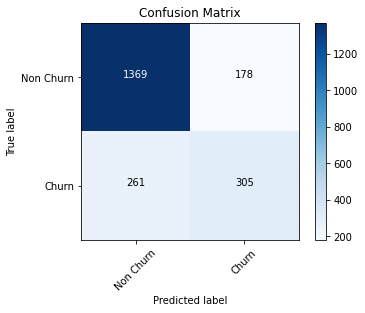

In [122]:
plot_confusion_matrix2(cnf_matrix)

# I just decided to manually calculate the confusion matrix to make the explanation easier

# Calculating the accuracy of the model

In [123]:
accuracy = (1369+305)/(1369+305+178+261)
print('The Accuarcy is:' , accuracy)

The Accuarcy is: 0.792238523426408


In [124]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Calculating the sensitivity of our logistic regression model

In [125]:
TP / float(TP+FN)

0.5388692579505301

# Calculating specificity

In [126]:
TN / float(TN+FP)

0.8849385908209437

# Calculate false postive rate - predicting churn when customer does not have churned

In [127]:
print(FP/ float(TN+FP))

0.11506140917905623


# Calculating positive predictive value 

In [128]:
print (TP / float(TP+FP))

0.6314699792960663


# Calculating Negative predictive value

In [129]:
print (TN / float(TN+ FN))

0.839877300613497


# ROC Curve
An ROC curve demonstrates several things:

It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity). The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test. The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [130]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(10, 7))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]' , fontsize = 15)
    plt.ylabel('True Positive Rate' , fontsize = 15)
    plt.title('Receiver operating characteristic example' , fontsize = 15)
    plt.legend(loc="lower right" , fontsize = 15)
    plt.show()

    return fpr, tpr, thresholds

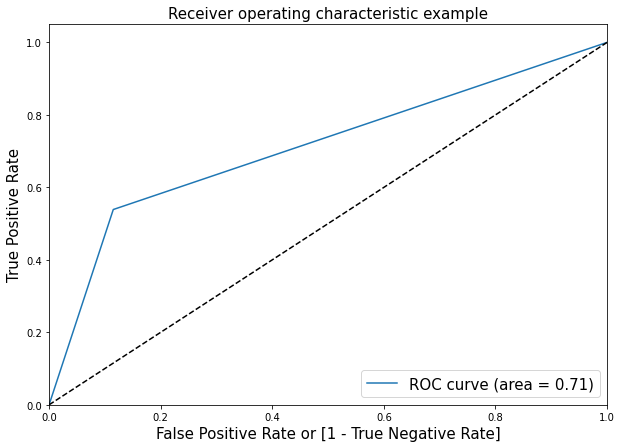

(array([0.        , 0.11506141, 1.        ]),
 array([0.        , 0.53886926, 1.        ]),
 array([2, 1, 0]))

In [131]:
draw_roc(y_pred_final.Churn, y_pred_final.predicted)

# Finding Optimal Cutoff Point / Threshold Selection

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity . This is our Threshold

In [132]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,CustID,Churn,Churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,4880,0,0.005627,0,1,0,0,0,0,0,0,0,0,0
1,1541,0,0.002007,0,1,0,0,0,0,0,0,0,0,0
2,1289,0,0.016689,0,1,0,0,0,0,0,0,0,0,0
3,5745,0,0.007485,0,1,0,0,0,0,0,0,0,0,0
4,4873,0,0.136090,0,1,1,0,0,0,0,0,0,0,0


In [133]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specitivity'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.Churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy  sensitivity  specitivity
0.0   0.0  0.267866     1.000000     0.000000
0.1   0.1  0.604827     0.943463     0.480931
0.2   0.2  0.688594     0.860424     0.625727
0.3   0.3  0.737814     0.757951     0.730446
0.4   0.4  0.772835     0.666078     0.811894
0.5   0.5  0.792239     0.538869     0.884939
0.6   0.6  0.790345     0.388693     0.937298
0.7   0.7  0.767629     0.199647     0.975436
0.8   0.8  0.738287     0.022968     1.000000
0.9   0.9  0.732134     0.000000     1.000000


# Let's plot accuracy sensitivity and specificity for various probabilities.

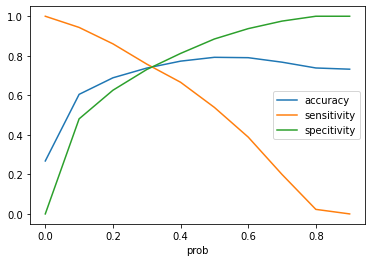

In [134]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specitivity'])

# Observations :

From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

Hence , our best threshold selection is 0.3

In [135]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.3 else 0)

In [136]:
y_pred_final.head()

,CustID,Churn,Churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,4880,0,0.005627,0,1,0,0,0,0,0,0,0,0,0,0
1,1541,0,0.002007,0,1,0,0,0,0,0,0,0,0,0,0
2,1289,0,0.016689,0,1,0,0,0,0,0,0,0,0,0,0
3,5745,0,0.007485,0,1,0,0,0,0,0,0,0,0,0,0
4,4873,0,0.136090,0,1,1,0,0,0,0,0,0,0,0,0


# Let's check the overall accuracy of the final model

In [137]:
metrics.accuracy_score( y_pred_final.Churn, y_pred_final.final_predicted)

0.7378135352579271

In [138]:
metrics.confusion_matrix( y_pred_final.Churn, y_pred_final.final_predicted )

array([[1130,  417],
       [ 137,  429]])

In [139]:
actual_1 = y_pred_final.Churn
predicted_1 = y_pred_final.final_predicted

In [140]:
cnf_matrix_1 = confusion_matrix(actual_1 , predicted_1)

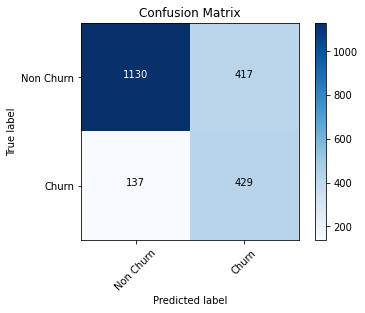

In [141]:
plot_confusion_matrix2(cnf_matrix_1)

# Explanation of some of the concepts 

There are few values given in this report / each category in the target (`Churn` or `Not Churn`):

* **Precision**  
* **Recall**  
* **F1-score**  

Let's explain each of them:

* **Precision** identifies the frequency with which a model was correct when predicting the positive class. That is:

$$Precision = \frac{\textrm{True Positives}}{\textrm{True Positives} + \textrm{False Positives}}$$

* **Recall** answers the following question: Out of all the possible positive labels, how many did the model correctly identify? That is:

$$Recall = \frac{\textrm{True Positives}}{\textrm{True Positives} + \textrm{False Negatives}}$$

* **F1-score** is the harmonic mean of **precision** and **recall**.

$$\textrm{F1-score} = 2  \frac{Precision * Recall}{Precision + Recall}$$


Precison is better for the `Not Churn` as well as Recall and F1-score.

Let's also show the confusion matrix.

# Done